In [1]:
from skimage.transform import resize
import numpy as np
import random
from skimage.filters import gaussian
from tqdm import tqdm
import matplotlib.cm as cm


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None, ):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
      [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    
    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap_back =  heatmap
    heatmap = tf.maximum(heatmap, 0)
    cam_max = tf.math.reduce_max(heatmap)
    
    if cam_max != 0:
        heatmap = heatmap / cam_max
        
    if(np.percentile(heatmap, 99) == np.min(heatmap)):
        heatmap = (heatmap_back - np.min(heatmap_back)) / (np.max(heatmap_back) - np.min(heatmap_back))

    
    return heatmap.numpy()

In [2]:
#Importing Necessary Libraries.

from PIL import Image
import numpy as np
import pandas as pd 
import os
import re
import cv2
from pathlib import Path

import matplotlib.pyplot as plt
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4024)])
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

import lime
from lime import lime_image
from matplotlib import pylab as P

import saliency.core as saliency
import glob2

from datetime import datetime, timedelta
from RISE_tf.explain_image import RISE


tf.__version__

'2.5.0'

In [3]:
INPUT_DIR = "/home/maia/Documents/Universidade/Universidade/UNIVERSIDADE/EXPERIMENTO/0DATASETS/EVAL_TESTE/OCT/"
OUTPUT_DIR = "./OUT/VGG-OCT-RANDOM/"
MODEL = "/home/maia/Documents/Universidade/Universidade/UNIVERSIDADE/EXPERIMENTO/1TRAIN_NEW_VGG_CUSTOM/VGG_NET/OCT/VGG-OCT-RANDOM/basetuned_model.h5"
INPUT_FILES = glob2.glob(os.path.join(INPUT_DIR, "*/*.jpeg"))
EVAL_SIZE = len(INPUT_FILES)

In [4]:
def image_generator(directory, res, batch_size=1):
    test_datagen = ImageDataGenerator()
    image_generator = test_datagen.flow_from_directory(
            directory,
            target_size=(res, res),
            color_mode= 'rgb',
            batch_size= batch_size,  
            class_mode= 'categorical',
            shuffle= False, 
            seed= 1337)
    return image_generator

In [5]:
class_idx_str = 'class_idx_str'
def call_model_function(images, call_model_args=None, expected_keys=None):
    target_class_idx =  call_model_args[class_idx_str]
    images = tf.convert_to_tensor(images)
    with tf.GradientTape() as tape:
        if expected_keys==[saliency.base.INPUT_OUTPUT_GRADIENTS]:
            tape.watch(images)
            _, output_layer = model(images)
            output_layer = output_layer[:,target_class_idx]
            gradients = np.array(tape.gradient(output_layer, images))
            return {saliency.base.INPUT_OUTPUT_GRADIENTS: gradients}
        else:
            conv_layer, output_layer = model(images)
            gradients = np.array(tape.gradient(output_layer, conv_layer))
            return {saliency.base.CONVOLUTION_LAYER_VALUES: conv_layer,
                    saliency.base.CONVOLUTION_OUTPUT_GRADIENTS: gradients}

In [6]:
def save_greyscale(out_dir, out_file, mask):
    Path.mkdir(Path(out_dir), parents=True, exist_ok=True)
    cv2.imwrite(str(Path(out_dir) / out_file),  cv2.cvtColor(mask*255,cv2.COLOR_GRAY2RGB))

def save_rgb(out_dir, out_file, mask):
    Path.mkdir(Path(out_dir), parents=True, exist_ok=True)
    cv2.imwrite(str(Path(out_dir) / out_file), cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
    
def save_heat(out_dir, out_file, mask):
    Path.mkdir(Path(out_dir), parents=True, exist_ok=True)
    plt.imsave(str(Path(out_dir) / out_file), arr = mask, cmap='gray', vmin = 0, vmax = 255)
    
def save_heat_image(out_dir, out_file, mask):
    Path.mkdir(Path(out_dir), parents=True, exist_ok=True)
    P.imsave(str(Path(out_dir) / out_file), arr = mask, cmap='gray')
    
def save_lime(out_dir, out_file, mask):
    Path.mkdir(Path(out_dir), parents=True, exist_ok=True)
    P.imsave(str(Path(out_dir) / out_file), arr = mask, cmap='gray', vmin= mask.min(), vmax=mask.max())
    
def save_blur(out_dir, out_file, mask):
    Path.mkdir(Path(out_dir), parents=True, exist_ok=True)
    P.imsave(str(Path(out_dir) / out_file), arr = mask, cmap=P.cm.gray, vmin=0, vmax=1)
    
from matplotlib import pylab as P
def ShowImage(im, title='', ax=None):
    if ax is None:
        P.figure()
    P.axis('off')
    P.imshow(im)
    P.title(title)

def ShowGrayscaleImage(im, file,  title='', ax=None):
    if ax is None:
        P.figure()
    P.axis('off')
    P.imsave(file, im, cmap=P.cm.gray, vmin=0, vmax=1)

def ShowHeatMap(im, file, ax=None):
    if ax is None:
        P.figure()
    P.axis('off')
    P.imsave(file, im, cmap='grey')
    
def abs_grayscale_norm(img):
    """Returns absolute value normalized image 2D."""
    assert isinstance(img, np.ndarray), "img should be a numpy array"
    
    shp = img.shape
    if len(shp)< 2:
        raise ValueError("Array should have 2 or 3 dims!")
    if len(shp)==2:
        img = np.absolute(img)
        img = img/float(img.max())
    else:
        img = saliency.VisualizeImageGrayscale(img)
    return img

def diverging_norm(img):
    """Returns image with positive and negative values."""
    assert isinstance(img, np.ndarray), "img should be a numpy array"
    shp = img.shape
    if len(shp)< 2:
        raise ValueError("Array should have 2 or 3 dims!")
    if len(shp)==2:
        imgmax = np.absolute(img).max()
        img = img/float(imgmax)
    else:
        img = saliency.VisualizeImageDiverging(img)
    return img

def plot_single_img(img, ax=False, norm=diverging_norm, show_axis=False, grayscale=False, cmap='gray', title='', fig_size=(4,4)):
    plt.figure(figsize=fig_size)
    if norm:
        img = norm(img)
    if not show_axis:
        plt.axis('off')
    plt.imshow(img, cmap=cmap)
    if title:
        plt.title(title)
    
def normalize_image(x):
    x = np.array(x).astype(np.float32)
    x_min = x.min()
    x_max = x.max()
    x_norm = (x - x_min) / (x_max - x_min)
    return x_norm

In [7]:
conv_layer_str = "block5_conv3"

model_path = MODEL
m = tf.keras.models.load_model(model_path)
m.summary()
conv_layer = m.get_layer(conv_layer_str)
model = tf.keras.models.Model([m.inputs], [conv_layer.output, m.output])   

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

Found 100 images belonging to 4 classes.
1/1 [==============================] - 3s 3s/step - loss: 4.1679 - accuracy: 0.2800
Test Loss:  4.167871475219727
Test Accuracy:  0.2800000011920929


<ipython-input-6-538294728fb7>:73: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=fig_size)


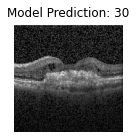

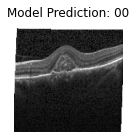

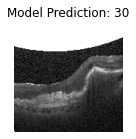

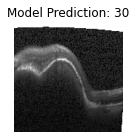

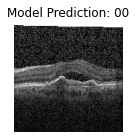

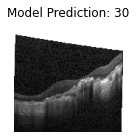

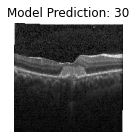

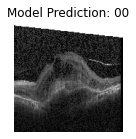

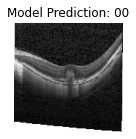

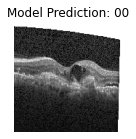

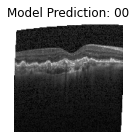

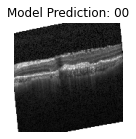

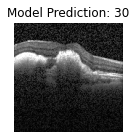

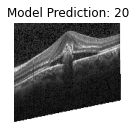

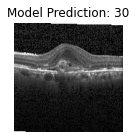

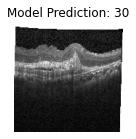

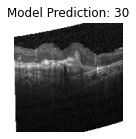

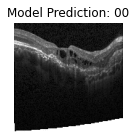

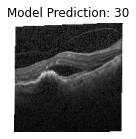

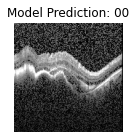

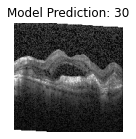

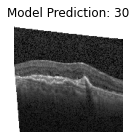

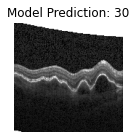

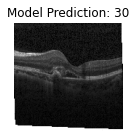

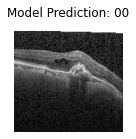

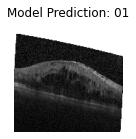

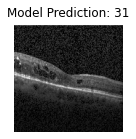

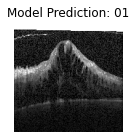

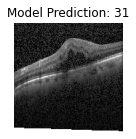

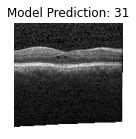

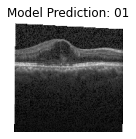

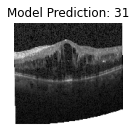

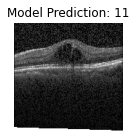

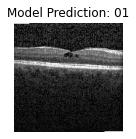

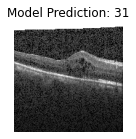

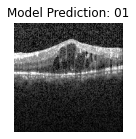

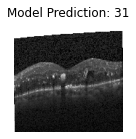

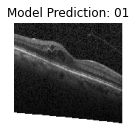

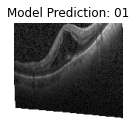

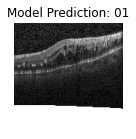

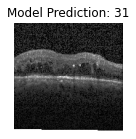

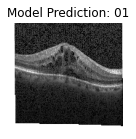

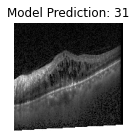

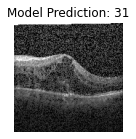

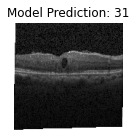

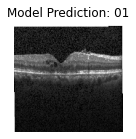

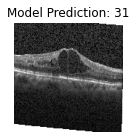

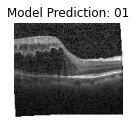

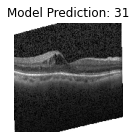

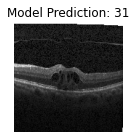

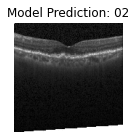

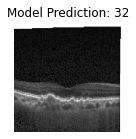

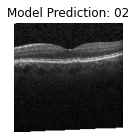

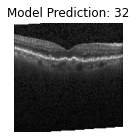

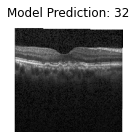

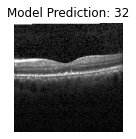

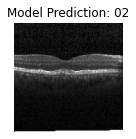

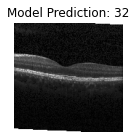

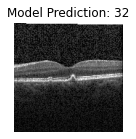

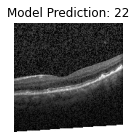

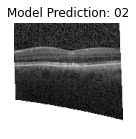

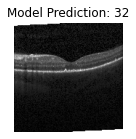

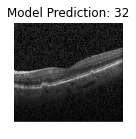

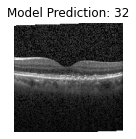

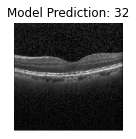

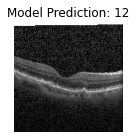

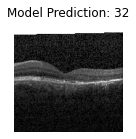

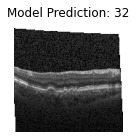

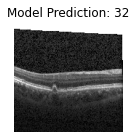

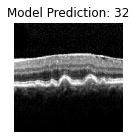

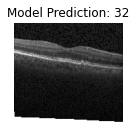

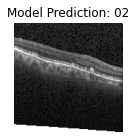

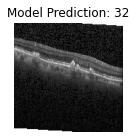

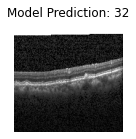

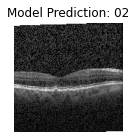

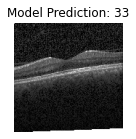

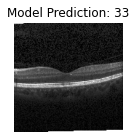

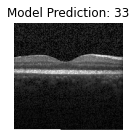

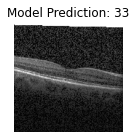

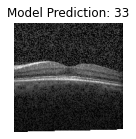

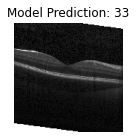

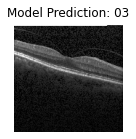

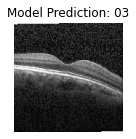

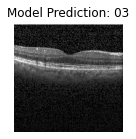

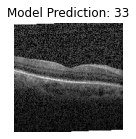

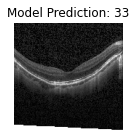

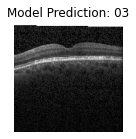

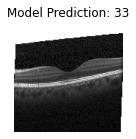

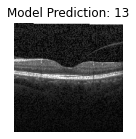

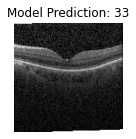

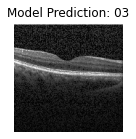

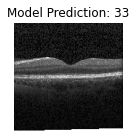

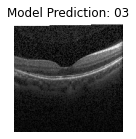

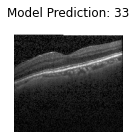

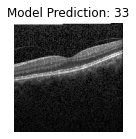

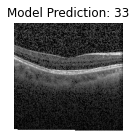

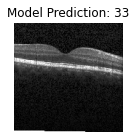

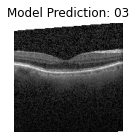

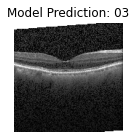

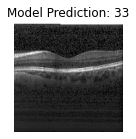

In [8]:
generator = image_generator(INPUT_DIR, 150, batch_size=EVAL_SIZE)
X, Y = generator.next()
logits = m.predict(X[:EVAL_SIZE])
predictions = logits.argmax(axis=1)

(eval_loss, eval_accuracy) = m.evaluate(generator, batch_size=EVAL_SIZE, verbose= 1)
print('Test Loss: ', eval_loss)
print('Test Accuracy: ', eval_accuracy)

for i in range(EVAL_SIZE):
    plot_single_img(X[i],
                    fig_size=(2,2),
                    title="Model Prediction: "+str(predictions[i]) +str(generator.classes[i]))

In [9]:
def vanilla_gradient(im, call_model_function, call_model_args):
    start_time = datetime.now()
    
    gradient_saliency = saliency.GradientSaliency()
    vanilla_mask_3d = gradient_saliency.GetMask(im, call_model_function, call_model_args)
    
    end_time = datetime.now()
    elapsed_seconds = int((end_time - start_time).total_seconds())
    print('Vanilla Elapsed time:', timedelta(seconds=elapsed_seconds))
    return gradient_saliency, vanilla_mask_3d

def smooth_vanilla_gradient(im, call_model_function, call_model_args, gradient_saliency):
    start_time = datetime.now()
    
    smoothgrad_mask_3d = gradient_saliency.GetSmoothedMask(im, call_model_function, call_model_args, stdev_spread=0.15,nsamples=50,magnitude=False)

    end_time = datetime.now()
    elapsed_seconds = int((end_time - start_time).total_seconds())
    print('Smooth Elapsed time:', timedelta(seconds=elapsed_seconds))
    return smoothgrad_mask_3d

def integrated_gradients_func(im, call_model_function, call_model_args):
    start_time = datetime.now()
    
    integrated_gradients = saliency.IntegratedGradients()
    baseline = np.zeros(im.shape)
    vanilla_integrated_gradients_mask_3d = integrated_gradients.GetMask(
      im, call_model_function, call_model_args, x_steps=50, x_baseline=baseline, batch_size=20)
    
    end_time = datetime.now()
    elapsed_seconds = int((end_time - start_time).total_seconds())
    print('IG Elapsed time:', timedelta(seconds=elapsed_seconds))
    return integrated_gradients, vanilla_integrated_gradients_mask_3d

def guided_IGS_func(im, call_model_function, call_model_args):
    start_time = datetime.now()
    
    guided_ig = saliency.GuidedIG()
    baselineGuided = np.zeros(im.shape)
    guided_ig_mask_3d = guided_ig.GetMask(im, call_model_function, call_model_args, x_steps=50, x_baseline=baselineGuided, max_dist=1.0, fraction=0.5)
    
    end_time = datetime.now()
    elapsed_seconds = int((end_time - start_time).total_seconds())
    print('Guided Elapsed time:', timedelta(seconds=elapsed_seconds))
    return guided_ig_mask_3d

def blur_IG_func(im, call_model_function, call_model_args):
    start_time = datetime.now()
    
    blur_ig = saliency.BlurIG()
    blur_ig_mask_3d = blur_ig.GetMask(im, call_model_function, call_model_args, batch_size=20)
    
    end_time = datetime.now()
    elapsed_seconds = int((end_time - start_time).total_seconds())
    print('Blur Elapsed time:', timedelta(seconds=elapsed_seconds))
    return blur_ig_mask_3d

def smooth_grad_func(im, call_model_function, call_model_args, integrated_gradients):
    start_time = datetime.now()
    
    baseline = np.zeros(im.shape)
    smoothgrad_integrated_gradients_mask_3d = integrated_gradients.GetSmoothedMask(im, call_model_function, call_model_args, x_steps=50, x_baseline=baseline, batch_size=20)

    end_time = datetime.now()
    elapsed_seconds = int((end_time - start_time).total_seconds())
    print('Smooth Elapsed time:', timedelta(seconds=elapsed_seconds))
    return smoothgrad_integrated_gradients_mask_3d

def grad_cam_func(img, m, conv_layer, prediction_class):
    start_time = datetime.now()
    gradcam = make_gradcam_heatmap(np.array([img]), m, conv_layer, pred_index=prediction_class)
    heatmap = np.uint8(255 * gradcam)
    jet = cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)
    
    end_time = datetime.now()
    elapsed_seconds = int((end_time - start_time).total_seconds())
    print('Grad Cam Elapsed time:', timedelta(seconds=elapsed_seconds))
    return jet_heatmap

def RISE_func(im, m, prediction_class):
    start_time = datetime.now()
    explainer = RISE()
    heatmaps, masks = explainer.explain(im, m)
    heatmap = heatmaps[prediction_class]
    end_time = datetime.now()
    elapsed_seconds = int((end_time - start_time).total_seconds())
    print('Rise Elapsed time:', timedelta(seconds=elapsed_seconds))
    return heatmap

def XRAI_func(im, call_model_function, call_model_args):
    start_time = datetime.now()
    xrai_object = saliency.XRAI()
    xrai_attributions = xrai_object.GetMask(im, call_model_function, call_model_args, batch_size=20)
    end_time = datetime.now()
    elapsed_seconds = int((end_time - start_time).total_seconds())
    print('XRAI Elapsed time:', timedelta(seconds=elapsed_seconds))
    return xrai_attributions

def LIME_func(im, m, prediction_class):
    start_time = datetime.now()
    explainer = lime_image.LimeImageExplainer(verbose=True)
    explanation = explainer.explain_instance(im.astype('double'), m.predict, top_labels=5, hide_color=0, num_samples=1000)
    temp, mask = explanation.get_image_and_mask(prediction_class, positive_only=False, num_features=5, hide_rest=True)
    dict_heatmap = dict(explanation.local_exp[prediction_class])
    heatmap = np.vectorize(dict_heatmap.get)(explanation.segments)
    end_time = datetime.now()
    elapsed_seconds = int((end_time - start_time).total_seconds())
    print('LIME Elapsed time:', timedelta(seconds=elapsed_seconds))
    return heatmap

In [10]:
def return_mask_dicts(im, im_org, call_model_function, call_model_args, prediction_class, m):

    output_masks_dict = {}
    
    #Original
    output_masks_dict["Original"] = im_org

    # Vanilla Gradient mask.
    #gradient_saliency, vanilla_mask_3d = vanilla_gradient(im, call_model_function, call_model_args)
    output_masks_dict["Gradient"] = vanilla_mask_3d
    
    # Smooth Gradient mask.
    output_masks_dict["SmoothGrad"] = smooth_vanilla_gradient(im, call_model_function, call_model_args, gradient_saliency) 

    # Smooth Input-Grad.
    output_masks_dict["Input-Grad"] = np.multiply(vanilla_mask_3d, im)

    #IntegratedGradients
    #integrated_gradients, vanilla_integrated_gradients_mask_3d = integrated_gradients_func(im, call_model_function, call_model_args)
    output_masks_dict["IntegratedGradients"] = vanilla_integrated_gradients_mask_3d

    # Compute the Guided IG mask.
    output_masks_dict["GuidedIG"] = guided_IGS_func(im, call_model_function, call_model_args)

    # Compute the vanilla mask and the Blur IG mask.
    output_masks_dict["BlurIG"] = blur_IG_func(im, call_model_function, call_model_args)

    # Smoothed mask for integrated gradients will take a while since we are doing nsamples * nsamples computations.
    #output_masks_dict["IGSmoothGrad"] = smooth_grad_func(im, call_model_function, call_model_args, integrated_gradients)

    #GradCAM
    output_masks_dict["GradCam"] = grad_cam_func(im, m, conv_layer_str, prediction_class)

    #RISE
    output_masks_dict["RISE"] = RISE_func(im, m, prediction_class)

    # Compute XRAI attributions with default parameters
    output_masks_dict["XRAI"] = XRAI_func(im, call_model_function, call_model_args)

    #LIME
    output_masks_dict["LIME"] = LIME_func(im, m, prediction_class)

    return output_masks_dict

In [11]:
results = []
logits = predictions
for i in range(EVAL_SIZE):
    call_model_args = {class_idx_str: logits[i]}
    nome = generator.filenames[i]
    results = return_mask_dicts(X[i], X[i], call_model_function, call_model_args, logits[i], m)
    for k, v in results.items():
        if(k == "Original"):
            mask_abs_norm = v
            mask_no_abs_norm = v
            mask_0_1_norm = v
        mask_abs_norm = abs_grayscale_norm(v)
        mask_no_abs_norm = diverging_norm(v)
        mask_0_1_norm = normalize_image(v)
        
        path= nome.split("/")[1].split(".")[0]+".png"
        save_lime(Path(OUTPUT_DIR+k), path, mask_abs_norm)

Grad Cam Elapsed time: 0:00:00
Grad Cam Elapsed time: 0:00:00
Grad Cam Elapsed time: 0:00:00
Grad Cam Elapsed time: 0:00:00
Grad Cam Elapsed time: 0:00:00
Grad Cam Elapsed time: 0:00:00
Grad Cam Elapsed time: 0:00:00
Grad Cam Elapsed time: 0:00:00
Grad Cam Elapsed time: 0:00:00
Grad Cam Elapsed time: 0:00:00
Grad Cam Elapsed time: 0:00:00
Grad Cam Elapsed time: 0:00:00
Grad Cam Elapsed time: 0:00:00
Grad Cam Elapsed time: 0:00:00
Grad Cam Elapsed time: 0:00:00
Grad Cam Elapsed time: 0:00:00
Grad Cam Elapsed time: 0:00:00
Grad Cam Elapsed time: 0:00:00
Grad Cam Elapsed time: 0:00:00
Grad Cam Elapsed time: 0:00:00
Grad Cam Elapsed time: 0:00:00
Grad Cam Elapsed time: 0:00:00
Grad Cam Elapsed time: 0:00:00
Grad Cam Elapsed time: 0:00:00
Grad Cam Elapsed time: 0:00:00
Grad Cam Elapsed time: 0:00:00
Grad Cam Elapsed time: 0:00:00
Grad Cam Elapsed time: 0:00:00
Grad Cam Elapsed time: 0:00:00
Grad Cam Elapsed time: 0:00:00
Grad Cam Elapsed time: 0:00:00
Grad Cam Elapsed time: 0:00:00
Grad Cam